### imports

In [10]:
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys

### get data

c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


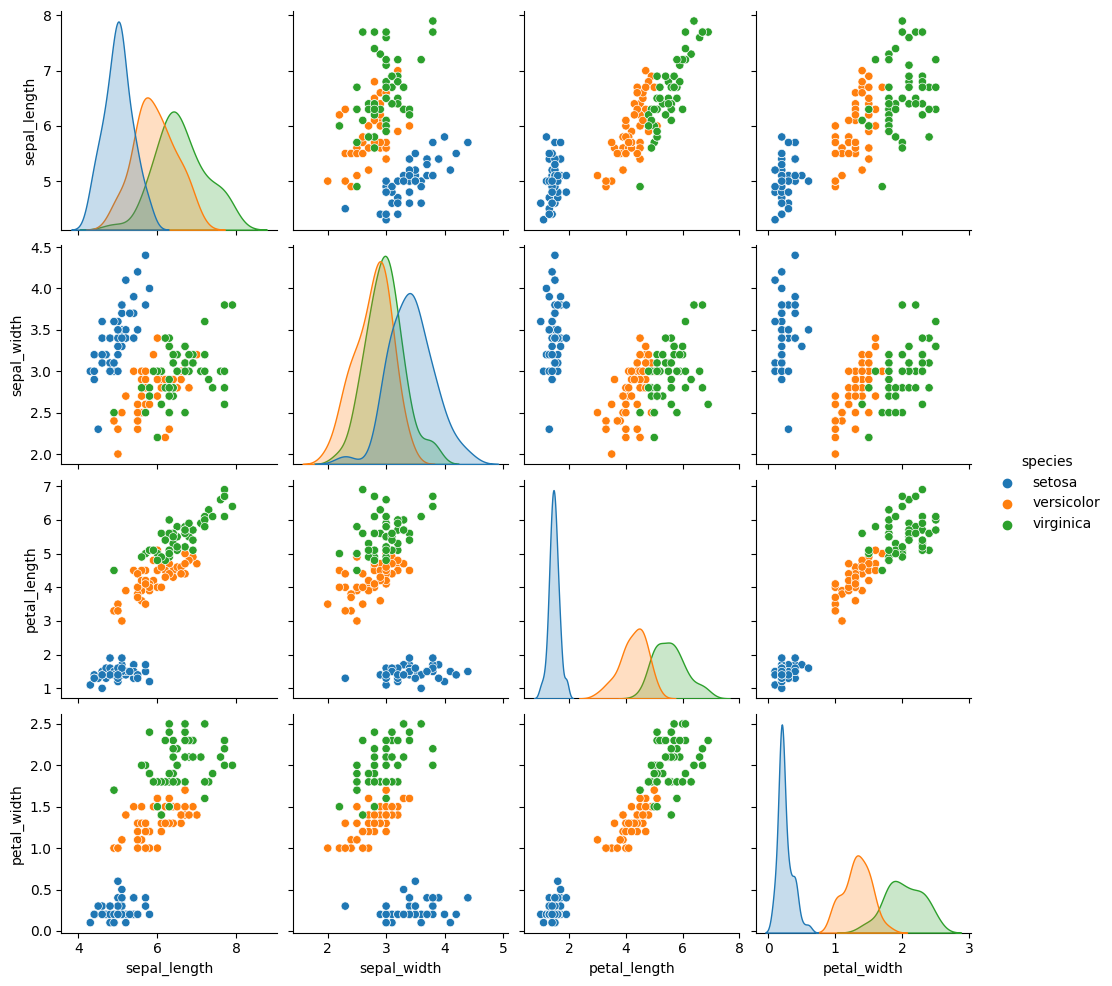

In [2]:
# get data
iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species")
# plt.show()

# organize data
data = torch.tensor(iris[iris.columns[0:4]].values, dtype=torch.float32)
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species == "setosa"] = 0
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2
# print(labels)

### ANN class

In [3]:
class ANNIris(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize, nLayers):
        super().__init__()

        # dictionary of layers
        self.layers = nn.ModuleDict()
        self.nlayers = nLayers

        # input layer
        self.layers["input"] = nn.Linear(inputSize, hiddenSize)

        # hidden layers
        for i in range(nLayers):
            self.layers[f"hidden {i}"] = nn.Linear(hiddenSize, hiddenSize)

        # output layer
        self.layers["output"] = nn.Linear(hiddenSize, outputSize)

    def forward(self, x):
        # input layer
        x = self.layers["input"](x)
        x = F.relu(x)

        # hidden layers
        for i in range(self.nlayers):
            x = self.layers[f"hidden {i}"](x)
            x = F.relu(x)

        # output layer
        x = self.layers["output"](x)
        x = F.softmax(x, dim=1)

        return x

In [4]:
# test the ANN
ANN = ANNIris(4, 64, 3, 2)
pred = ANN(data)
print(pred.shape)
print(ANN)
print("ANN tested")

torch.Size([150, 3])
ANNIris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=64, bias=True)
    (hidden 0): Linear(in_features=64, out_features=64, bias=True)
    (hidden 1): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=3, bias=True)
  )
)
ANN tested


### train model

In [15]:
def trainModel(model):
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # training
    train_accs = []
    test_accs = []
    epochs = 1000
    for i in range(epochs):
        # forward pass
        output = model(data)

        # compute loss
        loss = lossfun(output, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute accuracy
        matches = (torch.argmax(output, axis=1) == labels).type(torch.float32)
        accuracy = torch.mean(matches) * 100
        train_accs.append(accuracy)

        # test accuracy
        pred = model(data)
        predLabel = torch.argmax(pred, axis=1)
        accuracy = torch.mean((predLabel == labels).float()) * 100
        test_accs.append(accuracy)

    # no of trainable parameters
    nParams = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return model, nParams, test_accs, train_accs


# test the model
model, nParams, test_acc, train_accuracy = trainModel(ANN)
print(f"no of trainable parameters : {nParams} and accuracy : {train_accuracy[-1]}")

no of trainable parameters : 193 and accuracy : 96.66666412353516


### experiment on iris dataset

In [24]:
numlayers = range(1,5)           # number of hidden layers
numunits  = np.arange(10,151,15) # units per hidden layer

accuracies = np.zeros((2, len(numunits), len(numlayers)))

for unitidx in range(len(numunits)):
    for layeridx in range(len(numlayers)):

        # create and train a fresh model
        ANN = ANNIris(4, numunits[unitidx], 3, numlayers[layeridx])
        ANN, nParams, trainAcc, testAcc = trainModel(ANN)

        # store the results (average of final 5 epochs)
        accuracies[0, unitidx, layeridx] = np.mean(trainAcc[-5:])
        accuracies[1, unitidx, layeridx] = np.mean(testAcc[-5:])

        msg = f"Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}"
        sys.stdout.write(msg + "\r")

# approx time: 5 minutes

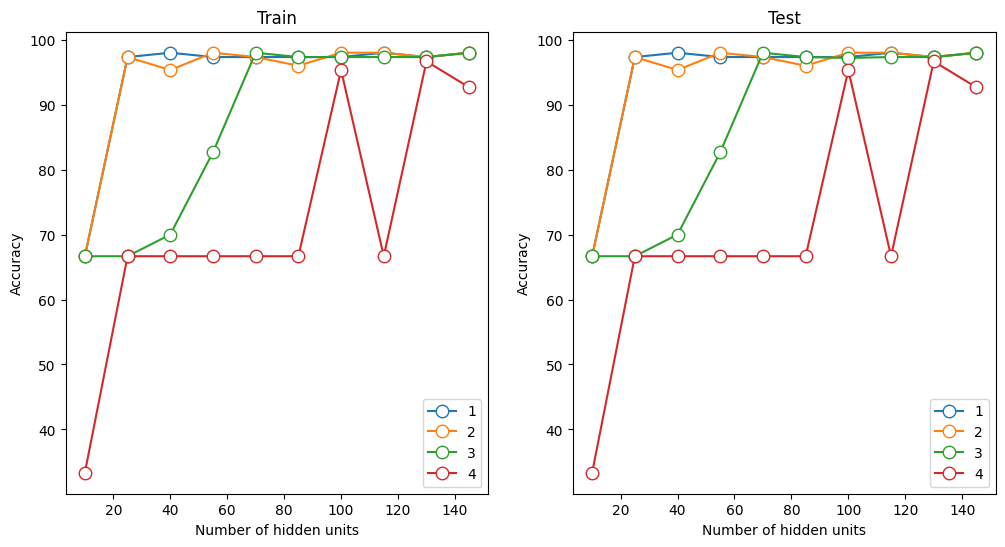

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(numunits, accuracies[0, :, :], "o-", markerfacecolor="w", markersize=9)
ax[1].plot(numunits, accuracies[1, :, :], "o-", markerfacecolor="w", markersize=9)

for i in range(2):
    ax[i].legend(numlayers)
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Number of hidden units")
    ax[i].set_title(["Train" if i == 0 else "Test"][0])

plt.show()

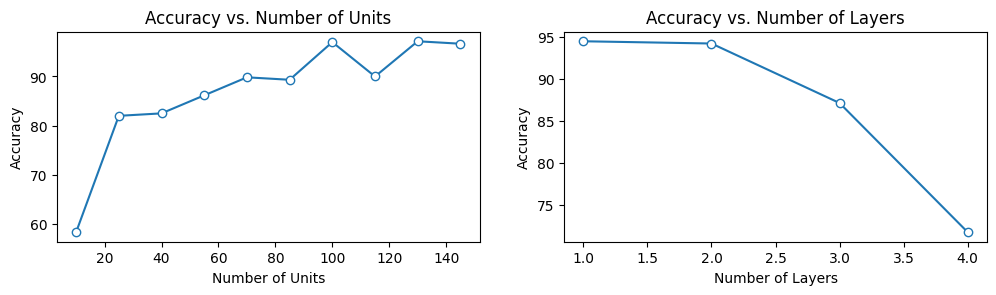

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(numunits, np.mean(accuracies[0], axis=1), "o-", markerfacecolor="w")
plt.title("Accuracy vs. Number of Units")
plt.xlabel("Number of Units")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.plot(numlayers, np.mean(accuracies[0], axis=0), "o-", markerfacecolor="w")
plt.title("Accuracy vs. Number of Layers")
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.show()

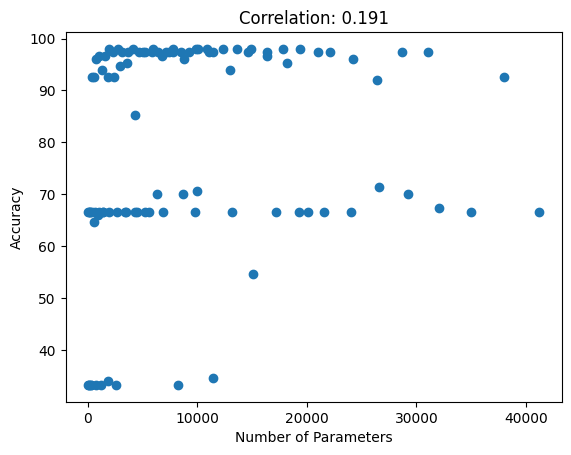

In [9]:
x = nParams.flatten()
y = accuracies.flatten()
# correlation btn them
corr = np.corrcoef(x, y)[0, 1]
plt.plot(x, y, "o")
plt.xlabel("Number of Parameters")
plt.ylabel("Accuracy")
plt.title(f"Correlation: {corr:.3f}")
plt.show()